# Solution 5: Kernels, Decision Trees

## Solution 5-4: Kernels and Decision Trees

# Kernel SVM

Similar to last week's exercise, implement a SVM class, but this time use a gaussian kernel and the dual optimization problem.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, cdist, squareform

class SVM:
    def __init__(self, C, kernel='linear', sigma=1.):
        self.C = C
        self.kernel = kernel
        self.sigma = sigma
    
    def get_kernel_matrix(self, X, X_other=None):
        if X_other is None:
            X_other = X
            
        if self.kernel == 'linear':
            return X @ X_other.T
        elif self.kernel == 'gaussian':
            D = cdist(X, X_other)**2
            K = np.exp((-0.5 / self.sigma**2) * D)
            return K
    
    def fit(self, X, y, verbose=False):
        eps = 1e-10

        K = self.get_kernel_matrix(X)

        def objective(a):
            return -np.sum(a) + 0.5 * (y * a) @ K @ (y * a)

        cons = ({'type':'ineq', 'fun': lambda a:a},
                {'type':'ineq', 'fun': lambda a: self.C-a},
                {'type':'eq',   'fun': lambda a:(a*y).sum()}
               )
        res = minimize(objective, np.zeros_like(y), constraints=cons)
        if verbose:
            print(res)
        assert res.x.min() > -eps
        assert res.x.max() < self.C + eps
        assert np.abs((res.x * y).sum()) < eps
        
        support_vector_mask = np.logical_and(res.x > eps, res.x < self.C - eps)
        margin_violator_mask = res.x >= self.C - eps
        self.alpha = res.x[support_vector_mask]
        self.support_vectors = X[support_vector_mask]
        self.margin_violators = X[margin_violator_mask]
        self.support_vector_labels = y[support_vector_mask]
        margin_values = self.support_vector_labels - self.alpha * self.support_vector_labels @ K[support_vector_mask][:,support_vector_mask]       
        self.margin = np.mean(margin_values)    
        
    def predict(self, X, labels=True):   
        K = self.get_kernel_matrix(self.support_vectors, X) 
        scores = self.alpha * self.support_vector_labels @ K + self.margin
        if not labels:
            return scores
        else:
            return np.sign(scores)

Train your SVM on the following data.

In [2]:
data = np.load('data.npy')

X = data[:, [0, 1]]
y = (data[:, 2] - 0.5) * 2

In [3]:
svm = SVM(C=100, kernel='gaussian', sigma=1.)
svm.fit(X,y, verbose=True)
y_pred = svm.predict(X)

     fun: -12.25837994574205
     jac: array([ 1.32848227,  1.68829739,  1.88160241,  1.93000448,  2.06892049,
        1.60376525,  1.49169195,  1.90655291,  1.48415744,  1.16181219,
        1.99099123,  1.97469604,  2.05878627,  1.54918373,  1.16491652,
        1.17542493,  1.54639101,  1.74555528,  1.3467052 ,  1.88801253,
        1.41562212,  1.16146767,  1.85191715,  1.16175568,  1.59504998,
        2.03126419,  1.85297477,  1.78972924,  1.97003424,  1.89337301,
        1.85938966,  1.89455521,  1.34177744,  1.82438099,  1.30508602,
       -1.16164482, -1.16191542, -0.18503129, -1.16164696, -1.06069279,
       -0.83561313, -0.60668647, -1.01915777, -0.69016802, -0.5293082 ,
       -0.761217  , -0.90701783, -0.96310031, -0.89371061, -1.02934706,
       -0.88623464, -1.01787281, -1.02402222, -0.59735513, -0.39889824,
       -1.1619699 , -1.16186237, -0.87717712, -0.92928255, -1.16180921,
        0.47258472, -1.16168535, -1.12519193, -1.16075575, -0.98780048,
       -0.74415696, -0.79

Visualize the data points, their predicted labels, the decision and margin boundaries as well as the support vectors.

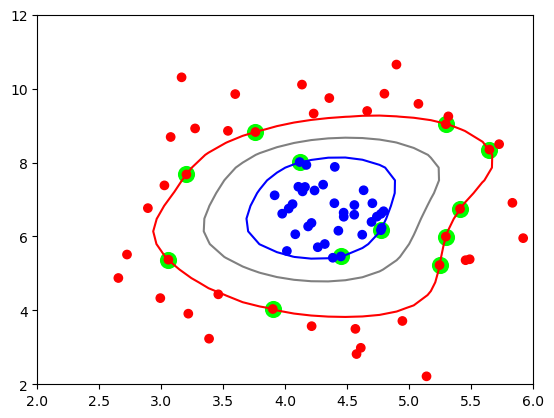

array([], shape=(0, 2), dtype=float64)

In [4]:
xx, yy = np.meshgrid(np.linspace(2, 6, 30), np.linspace(2, 12, 30))
z = svm.predict(np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1), labels=False)
z = z.reshape(xx.shape)

plt.scatter(svm.support_vectors[:,0], svm.support_vectors[:,1], s=128, c='lime')
plt.scatter(svm.margin_violators[:,0], svm.margin_violators[:,1], s=128, c='gray')
plt.scatter(X[:,0], X[:,1], c=['r' if y_i==1 else 'b' for y_i in y_pred ])
plt.contour(xx, yy, z, levels=[-1,0,1], colors=['blue', 'gray', 'red'])
plt.show()

svm.margin_violators

Assume, we train a hard-margin SVM. What happens if we use a linear kernel for data that is not linearly separable. Can this happen with a gaussian kernel as well? Why?

With a linear hard-margin SVM the optimization problem has no solution for inseparable data. With the gaussian kernel, this cannot happen. The reason is the the gaussian kernel corresponds to a scalar product in an infinitely dimensional space. In this in infinitely dimensional space, all finite sets of distinct samples are linearly separable.

# Decision Tree
Here, we implement a simplified version of the decision tree. 
We make the following simplifications/assumptions:
* target values are only 0 and 1
* for splitting, we consider all values that lie exactly in the middle of two consecutive values (after ordering) for that attribute
* the split criterion is the information gain
* we continue splitting nodes until all the remaining samples have the same class or the same attribute values
* we do not apply any regularization and pruning techniques
* you don't have to reuse computation results from parent nodes

In [5]:
import numpy as np

class DecisionTree:   
    def __init__(self):
        self.child1 = None # used if internal node
        self.child2 = None # used if internal node
        self.split = None # used if internal node
        self.label = None # used if leaf node
        
    def fit(self, X, y):
        if len(np.unique(y)) == 1:
            self.label = y[0]
    
        else:
            split = self.get_split(X,y)
            if split is None:
                self.label = np.mean(y)
            else:
                self.split = split
                mask1 = X[:, split['feature']] > split['value']
                mask2 = np.logical_not(mask1)

                self.child1 = DecisionTree()
                self.child2 = DecisionTree()
                self.child1.fit(X[mask1], y[mask1])
                self.child2.fit(X[mask2], y[mask2])
        
    def get_split(self, X, y):
        split_candidates = []
        gains = []
        for f in range(X.shape[1]):
            split, gain = self.get_split_for_attribute(X,y,f)
            split_candidates.append(split)
            gains.append(gain)
            
        best_index = np.argmax(gains)
        return split_candidates[best_index] if gains[best_index] != -np.inf else None
    
    def get_split_for_attribute(self, X, y, f):
        Xf = X[:,f]
        split_values = np.sort(np.unique(Xf))
        split_values = (split_values[1:] + split_values[:-1]) / 2
        if len(split_values) == 0:
            return None, -np.inf
        
        gains = []
        for value in split_values:
            mask1 = Xf > value
            mask2 = np.logical_not(mask1)
            gain = self.compute_gain(y[mask1], y[mask2])
            gains.append(gain)
        
        index = np.argmax(gains)
        gain = gains[index]
        value = split_values[index]
        split = {'feature':f, 'value':value}
        return split, gain
    
    def compute_gain(self, y1, y2):
        eps = 1e-10
        if len(y1) == 0 or len(y2) == 0:
            return - np.inf
        else:
            p1 = np.mean(y1)
            p2 = np.mean(y2)
            entropy1 = - p1 * np.log(p1 + eps) - (1-p1) * np.log(1 - p1 + eps)
            entropy2 = - p2 * np.log(p2 + eps) - (1-p2) * np.log(1 - p2 + eps)
            gain = -(len(y1) * entropy1 + len(y2) * entropy2) / (len(y1) + len(y2))
            return gain
            
    def predict(self, X):
        y = []
        for x in X:
            y.append(self.predict_sample(x.reshape(1,-1)))
        return np.array(y)
            
    def predict_sample(self, X):
        assert len(X) == 1
        if self.label is not None:
            return self.label
        else:
            mask1 = X[:,self.split['feature']] > self.split['value']
        
        if mask1:
            return self.child1.predict_sample(X)
        else:
            return self.child2.predict_sample(X)   

Fit your decision tree to the following toy dataset. Visualize the resulting predictions with a scatter plot and add the decision boundary.

In [6]:
np.random.seed(0)
X = np.random.uniform(0,1,size=(100,2))
y = (X[:,0] < X[:,1]).astype(int)

In [7]:
dt = DecisionTree()
dt.fit(X,y)

In [8]:
y_pred = dt.predict(X)
(y_pred == y).all()

True

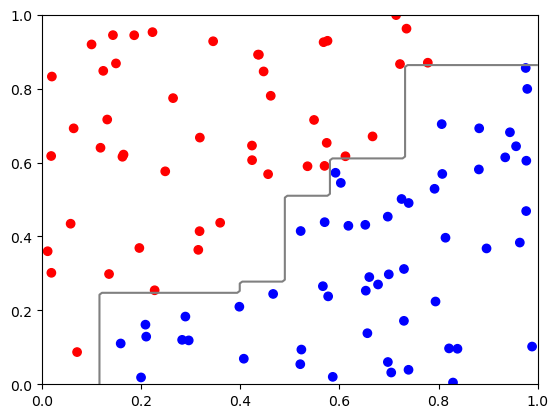

In [9]:
import matplotlib.pyplot as plt
xx, yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
z = dt.predict(np.concatenate([xx.reshape(-1,1), yy.reshape(-1,1)], axis=1))
z = z.reshape(xx.shape)

#plt.scatter(xx.flatten(),yy.flatten(), c=z.flatten())
plt.scatter(X[:,0], X[:,1], c=['r' if y_i==1 else 'b' for y_i in y_pred])
plt.contour(xx, yy, z, levels=[0.5], colors=['gray'])
plt.show()

Can you see a weakness of decision trees? What is the reason for that?

Apparently, interactions between features are modeled in a rather cumbersome manner, e.g. we need lots of splits to get this simple diagonal decision boundary. The reason for that is that we only consider splits on single attributes. However, positive effects of this are speed and integrated feature selection.

Can we also employ decision trees for regression? What would we have to modify?

We can easily adapt decision trees for regression. We just need to change the split criterion, for instance to variance, and the leaf node predictions, for instance, we can use the mean of the target values.